# Univariate Time Series With Stacked LSTM, BiLSTM, and NeuralProphet


---



Developing Deep learning LSTM, BiLSTM models, and NeuralProphet for multi-step forecasting of stock price
* This notebook is generated for the article: Univariate Time Series With Stacked LSTM, BiLSTM, and NeuralProphet.

# Import libraries



In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from pylab import rcParams
from sklearn.model_selection import train_test_split as split
import warnings
import itertools
warnings.filterwarnings("ignore")
from fbprophet import Prophet
from IPython import display
from matplotlib import pyplot
import os
import re
#from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

# Load data + Preprocess + Feature Transformation

In [ ]:
data = pd.read_csv('AAPL.csv')

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

In [ ]:
data.info()

In [ ]:

data=data.set_index(['Date'])
data.head()

In [ ]:
data.reset_index(inplace=True)

In [ ]:
data.info()


In [ ]:
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

In [ ]:
col_order = ['Date','Adj Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

In [ ]:
# X1=  x1[['beds','Reviews','rating']]
# y= x1['Log_price']

In [ ]:
data_feature_selected['differenced_trasnformation_demand'] = data_feature_selected['Adj Close'].diff().values
data_feature_selected.head()

In [ ]:
data_feature_selected['differenced_demand_filled'] = np.where(pd.isnull(data_feature_selected['differenced_trasnformation_demand']), data_feature_selected['Adj Close'], data_feature_selected['differenced_trasnformation_demand'])
data_feature_selected.head()

In [ ]:
data_feature_selected['differenced_inv_transformation_demand'] = data_feature_selected['differenced_demand_filled'].cumsum()
np.testing.assert_array_equal(data_feature_selected['Adj Close'].values, data_feature_selected['differenced_inv_transformation_demand'].values)

In [ ]:
data_feature_selected.head()

# plot

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
FIGURE_SIZE = (20, 10)
plt.rcParams['axes.grid'] = True

%matplotlib inline


In [ ]:
data.set_index('Date')['Close'].plot(figsize=FIGURE_SIZE)

In [ ]:
data_feature_selected.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

# Trasnformation 

In [ ]:
data_feature_selected.set_index('Date')['differenced_trasnformation_demand'].plot(figsize=FIGURE_SIZE)

In [ ]:
data_feature_selected.set_index('Date')['differenced_demand_filled'].plot(figsize=FIGURE_SIZE)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
data_feature_selected['differenced_trasnformation_demand'][1:].plot(c='grey')
data_feature_selected['differenced_trasnformation_demand'][1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
data_feature_selected['differenced_trasnformation_demand'][1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
data_feature_selected['differenced_demand_filled'][1:].plot(c='grey')
data_feature_selected['differenced_demand_filled'][1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
data_feature_selected['differenced_demand_filled'][1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

Exporting data to use later as stock.csv

In [ ]:
#data_feature_selected.to_csv("stock.csv", index=False)

KPSS test , to check stationary

In [ ]:

# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(data_feature_selected['differenced_demand_filled'])

In [ ]:
def build_temporal_features(data: pd.DataFrame) -> pd.DataFrame:
    # Temporal features
    data_feature_selected['date'] = pd.to_datetime(data['Date'])
    data_feature_selected['year'] = data_feature_selected['Date'].dt.year
    data_feature_selected['month'] = data_feature_selected['Date'].dt.month
    data_feature_selected['week'] = data_feature_selected['Date'].dt.week
    data_feature_selected['day'] = data_feature_selected['Date'].dt.day
    data_feature_selected['dayofweek'] = data_feature_selected['Date'].dt.dayofweek
    #data['quarter'] = data['date'].dt.quarter
    data_feature_selected['week_of_month'] = data['day'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    data_feature_selected['is_weekend'] = (data_feature_selected['dayofweek'] > 5).astype(np.int8)
    
    return data_feature_selected

In [ ]:
df1 = build_temporal_features(data_feature_selected)
df1.head()

In [ ]:
df1[df1.is_weekend == 1]

In [ ]:
fig = plt.figure(figsize=(10,8))
sns.distplot(df1['differenced_demand_filled']).set_title("Distribution Plot Adj Close diff -AAPL")
#ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save old data after transformation  and load 

In [5]:
df1 = pd.read_csv('stock.csv')

In [6]:
df1

,Date,Adj Close,differenced_trasnformation_demand,differenced_demand_filled,differenced_inv_transformation_demand,date,year,month,week,day,dayofweek,week_of_month,is_weekend
0,2010-01-04,6.562589,NaN,6.562589,6.562589,2010-01-04,2010,1,1,4,0,1,0
1,2010-01-05,6.573936,0.011347,0.011347,6.573936,2010-01-05,2010,1,1,5,1,1,0
2,2010-01-06,6.469368,-0.104568,-0.104568,6.469368,2010-01-06,2010,1,1,6,2,1,0
3,2010-01-07,6.457407,-0.011961,-0.011961,6.457407,2010-01-07,2010,1,1,7,3,1,0
4,2010-01-08,6.500340,0.042933,0.042933,6.500340,2010-01-08,2010,1,1,8,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,2021-10-27,148.850006,-0.470001,-0.470001,148.850006,2021-10-27,2021,10,43,27,2,4,0
2976,2021-10-28,152.570007,3.720001,3.720001,152.570007,2021-10-28,2021,10,43,28,3,4,0
2977,2021-10-29,149.800003,-2.770004,-2.770004,149.800003,2021-10-29,2021,10,43,29,4,5,0
2978,2021-11-01,148.960007,-0.839996,-0.839996,148.960007,2021-11-01,2021,11,44,1,0,1,0


Choose specific days with mask

In [ ]:

mask = (df1['Date'] > '2010-01-01') & (df1['Date'] <= '2021-12-31')
print(df1.loc[mask])

In [ ]:
df12=df1.loc[mask]

In [ ]:
df12

In [9]:
#X=  df12[['Date']]
#y= df12['differenced_demand_filled']


selecting y as ['Adj Close']

In [48]:
y = df1['Adj Close']

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(np.array(y).reshape(-1,1))

In [50]:
##splitting dataset into train and test split
training_size=int(len(y)*0.65)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:1]

In [51]:
training_size,test_size

(1937, 1043)

In [52]:
train_data[2]

array([0.00384731])

In [53]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [54]:
import numpy

In [55]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [56]:
print(X_train.shape), print(y_train.shape)

(1836, 100)
(1836,)


(None, None)

In [57]:
print(X_test.shape), print(ytest.shape)

(942, 100)
(942,)


(None, None)

In [58]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [59]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout ,BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.initializers import RandomNormal, Constant


# Tunning LSTM

In [85]:

# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(150))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')




In [86]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 100, 150)          91200     
                                                                 
 dropout_26 (Dropout)        (None, 100, 150)          0         
                                                                 
 lstm_33 (LSTM)              (None, 100, 150)          180600    
                                                                 
 lstm_34 (LSTM)              (None, 100, 150)          180600    
                                                                 
 dropout_27 (Dropout)        (None, 100, 150)          0         
                                                                 
 lstm_35 (LSTM)              (None, 150)               180600    
                                                                 
 dropout_28 (Dropout)        (None, 150)              

In [87]:
#history= model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=54,batch_size=64,verbose=1)

EarlyStopping


In [88]:
from tensorflow.keras.callbacks import EarlyStopping


In [89]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(X_train,y_train,validation_data=(X_test,ytest),
        callbacks=[monitor],verbose=1,epochs=1000)

Epoch 1/1000
58/58 [==============================] - 54s 772ms/step - loss: 8.8362e-04 - val_loss: 0.0067
Epoch 2/1000
58/58 [==============================] - 44s 751ms/step - loss: 9.3615e-05 - val_loss: 0.0016
Epoch 3/1000
58/58 [==============================] - 43s 744ms/step - loss: 7.9681e-05 - val_loss: 0.0037
Epoch 4/1000
58/58 [==============================] - 43s 743ms/step - loss: 7.6155e-05 - val_loss: 9.3513e-04
Epoch 5/1000
58/58 [==============================] - 43s 743ms/step - loss: 7.9132e-05 - val_loss: 0.0024
Epoch 6/1000
58/58 [==============================] - 43s 743ms/step - loss: 7.2373e-05 - val_loss: 0.0019
Epoch 7/1000
58/58 [==============================] - 43s 742ms/step - loss: 7.1526e-05 - val_loss: 8.4308e-04
Epoch 8/1000
58/58 [==============================] - 44s 755ms/step - loss: 6.1989e-05 - val_loss: 7.4183e-04
Epoch 9/1000
58/58 [==============================] - 43s 745ms/step - loss: 6.5635e-05 - val_loss: 7.0740e-04
Epoch 10/1000
58/58 [

***Running each time might change results***

 to avoid 
*   set seed
*   save weights of the model or save the whole model 

> 











In [99]:
model.save("lstm2022.h5") #save model 
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

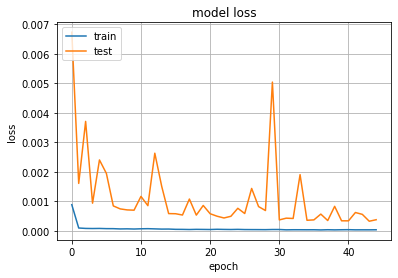

In [90]:
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

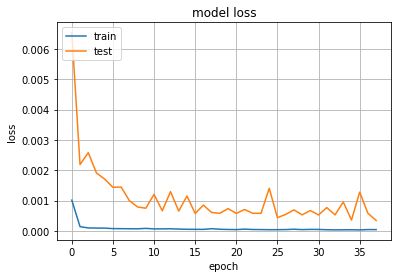

In [61]:
plt.plot(history.history['loss']) # t
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [ ]:
plt.plot(history.history['loss']) # tn
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

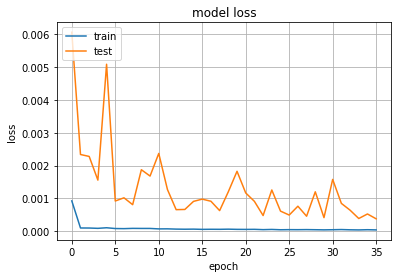

In [51]:
plt.plot(history.history['loss']) # t
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

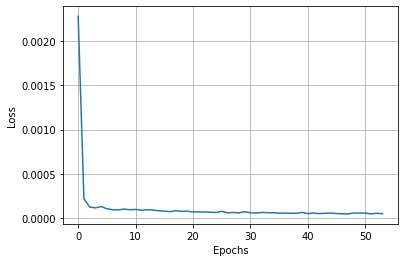

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

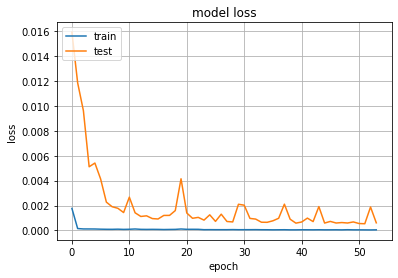

In [ ]:
plt.plot(history.history['loss']) # t
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

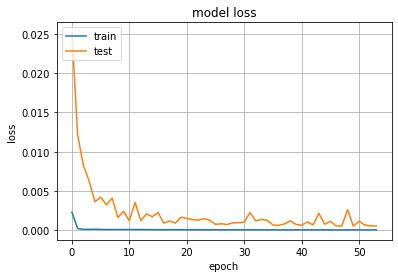

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.7.0'

In [91]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [92]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [93]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20.75319059791041

In [94]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, test_predict)

80.09842461981907

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, train_predict)

20.030015593076516

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, test_predict)

79.20435869404275

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

21.391395060229833

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

87.37868881632028

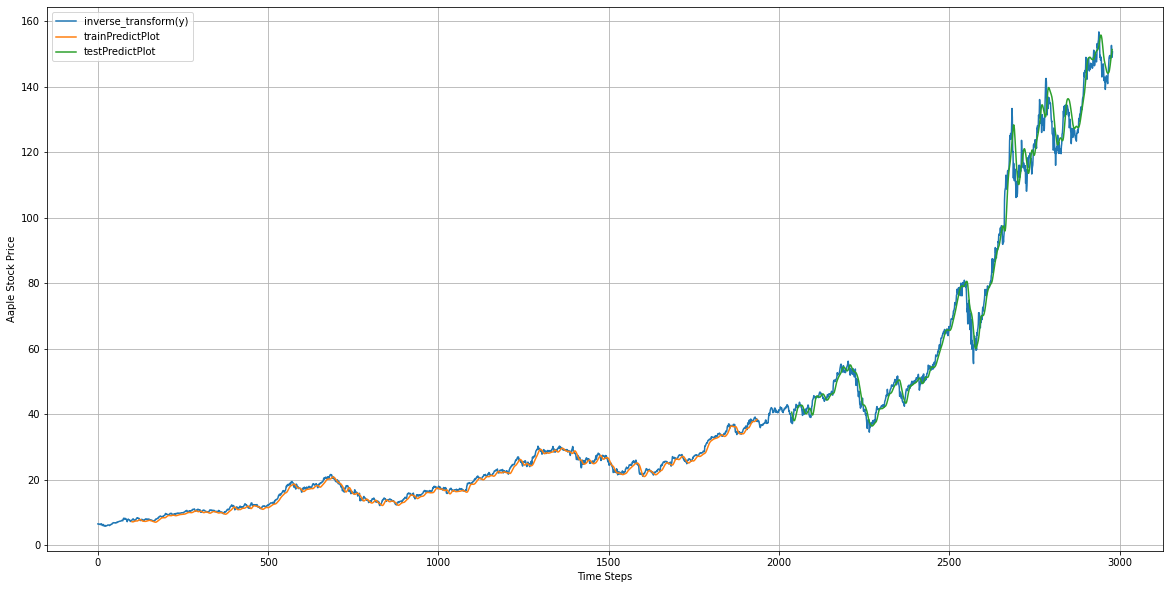

In [97]:
### Plotting 
# shift train predictions for plotting
look_back=100
fig, ax = plt.subplots(figsize=(20,10))
trainPredictPlot = numpy.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(y)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['inverse_transform(y)','trainPredictPlot','testPredictPlot'])
plt.xlabel('Time Steps')
plt.ylabel('Aaple Stock Price')
plt.show()

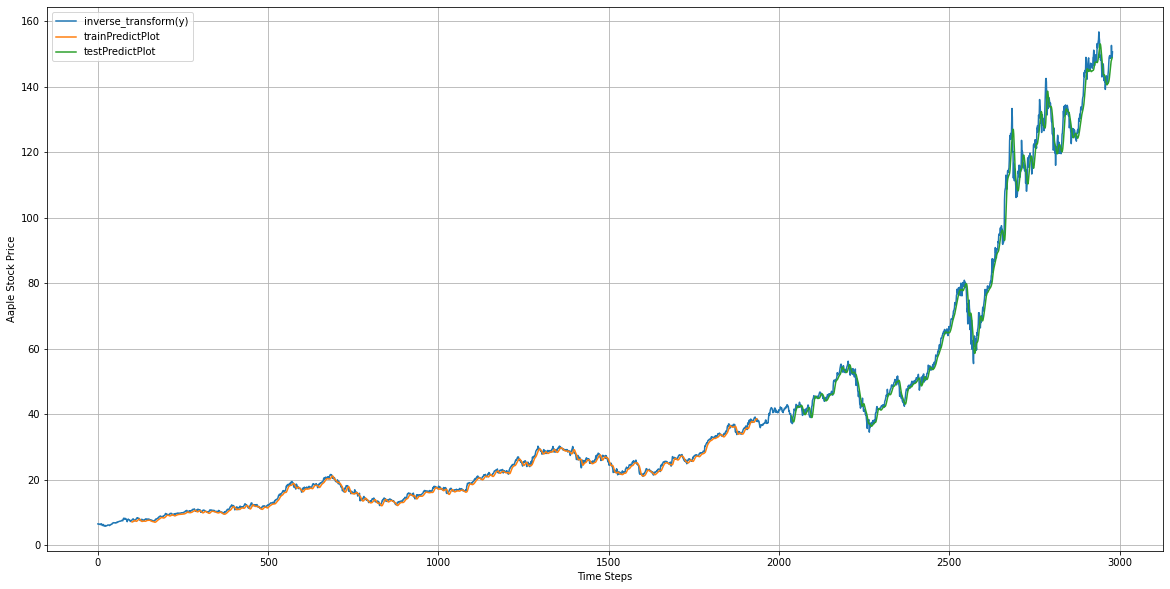

In [29]:
## Plotting 
# shift train predictions for plotting
look_back=100
fig, ax = plt.subplots(figsize=(20,10))
trainPredictPlot = numpy.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(y)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['inverse_transform(y)','trainPredictPlot','testPredictPlot'])
plt.xlabel('Time Steps')
plt.ylabel('Aaple Stock Price')
plt.show()

In [ ]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=1)
test_mse = model.evaluate(X_test, ytest, verbose=1)


30/30 [==============================] - 3s 108ms/step - loss: 5.4543e-04


In [ ]:
train_mse > test_mse

False

- Underfitting – Validation and training error high
- Overfitting – Validation error is high, training error low
- Good fit – Validation error low, slightly higher than the training error
- Unknown fit - Validation error low, training error 'high'


In [ ]:
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.000, Test: 0.001


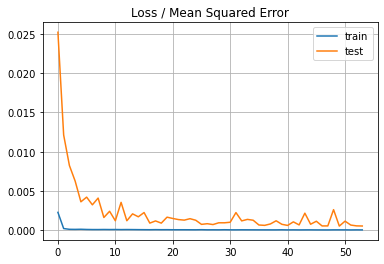

In [ ]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


If validation loss >> training loss you can call it overfitting.
If validation loss  > training loss you can call it some overfitting.
If validation loss  < training loss you can call it some underfitting.
If validation loss << training loss you can call it underfitting.

# Future forecasting 

In [ ]:
len(test_data), len(train_data) # 2021-11-02 test-data last date

(1043, 1937)

In [ ]:
x_input=test_data[943:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(y)

2980

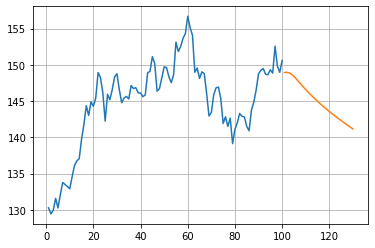

In [ ]:
plt.plot(day_new,scaler.inverse_transform(y[2880:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

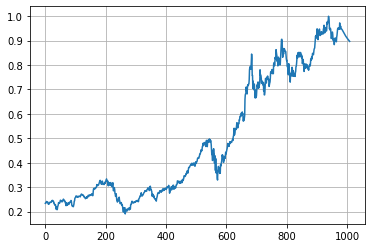

In [ ]:
df3=y.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])


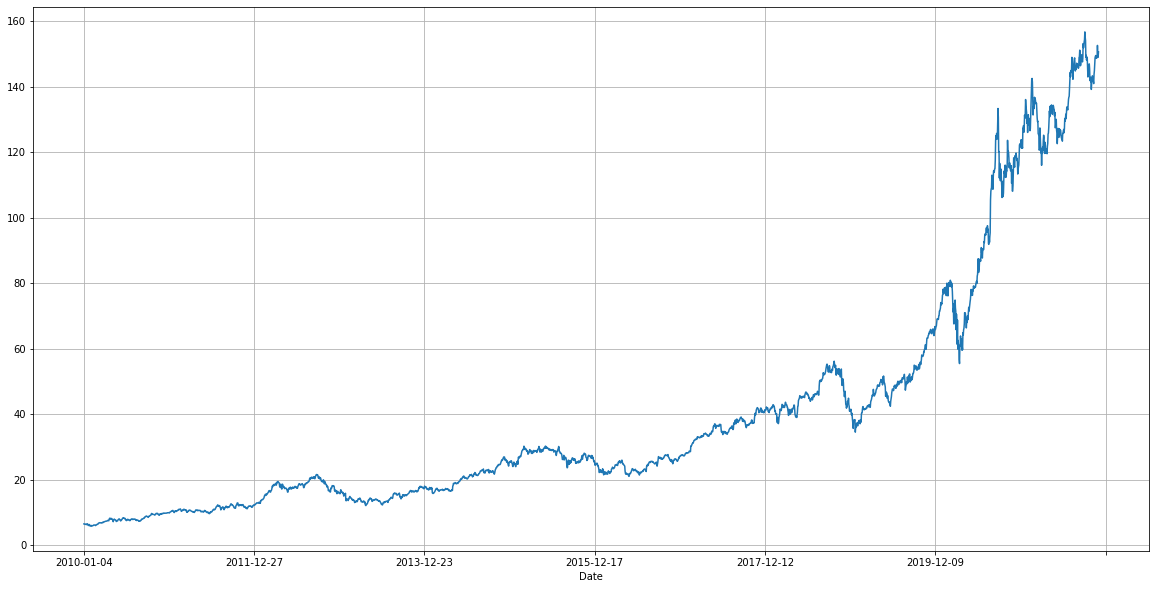

In [ ]:
df1.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

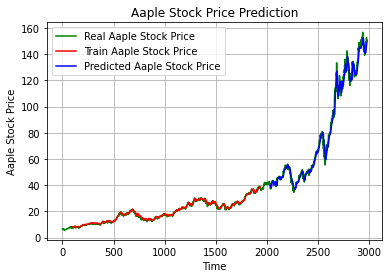

In [ ]:
# Visualising the results. with details 

plt.plot(scaler.inverse_transform(y), color='Green', label='Real Aaple Stock Price')
plt.plot(trainPredictPlot, color='Red', label='Train Aaple Stock Price')
plt.plot(testPredictPlot, color='Blue', label='Predicted Aaple Stock Price')

plt.title('Aaple Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Aaple Stock Price')
plt.legend()
plt.show()

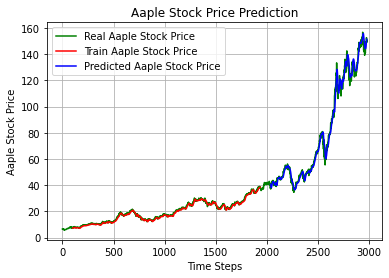

In [96]:
# Visualising the results. 

plt.plot(scaler.inverse_transform(y), color='Green', label='Real Aaple Stock Price')
plt.plot(trainPredictPlot, color='Red', label='Train Aaple Stock Price')
plt.plot(testPredictPlot, color='Blue', label='Predicted Aaple Stock Price')

plt.title('Aaple Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Aaple Stock Price')
plt.legend()
plt.show()

# Bidirectional LSTM

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional


In [ ]:
tf.random.set_seed(1234)

In [ ]:

modell = Sequential()
modell.add(Bidirectional(LSTM(100, activation='relu', input_shape=(100,1)))) #elu
#modell.add(Bidirectional(LSTM(50, dropout=0.5)))

#modell.add(Bidirectional(LSTM(100, dropout=0.5)))
#modell.add(BatchNormalization(momentum=0.6))
modell.add(Dense(1))
modell.compile(loss='mean_squared_error', optimizer='adam') #rmsprop adam




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)

history1=modell.fit(X_train,y_train,validation_data=(X_test,ytest),
        callbacks=[monitor],verbose=1,epochs=1000)

Epoch 1/1000
58/58 [==============================] - 10s 130ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 2/1000
58/58 [==============================] - 7s 123ms/step - loss: 6.9045e-05 - val_loss: 0.0045
Epoch 3/1000
58/58 [==============================] - 7s 123ms/step - loss: 5.0616e-05 - val_loss: 0.0214
Epoch 4/1000
58/58 [==============================] - 7s 122ms/step - loss: 4.1579e-05 - val_loss: 0.0956
Epoch 5/1000
58/58 [==============================] - 7s 123ms/step - loss: 3.6684e-05 - val_loss: 0.7866
Epoch 6/1000
58/58 [==============================] - 7s 123ms/step - loss: 3.3519e-05 - val_loss: 0.1545
Epoch 7/1000
58/58 [==============================] - 7s 123ms/step - loss: 2.8318e-05 - val_loss: 0.0865
Epoch 8/1000
58/58 [==============================] - 7s 127ms/step - loss: 2.7666e-05 - val_loss: 0.0919
Epoch 9/1000
58/58 [==============================] - 7s 123ms/step - loss: 2.5015e-05 - val_loss: 0.0526
Epoch 10/1000
58/58 [============================

In [ ]:
modell.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 200)              81600     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


***Running each time might change results***

*   List item
*   List item

> Indented block





In [ ]:
modell.save("my_del.h5") #save model 
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

In [ ]:
modell.save_weights('myfalse_weights.h5')
#modell.load_weights('my_model_weights.h5')

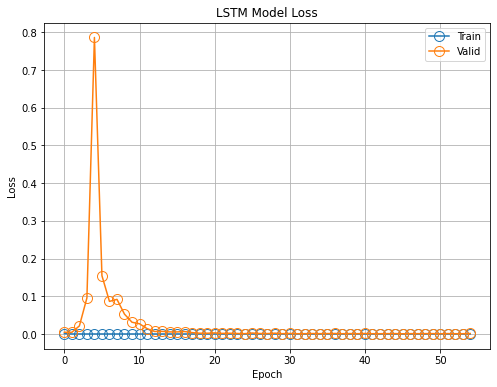

In [ ]:
plot_1(history1, 'Training / Validation Losses from History')

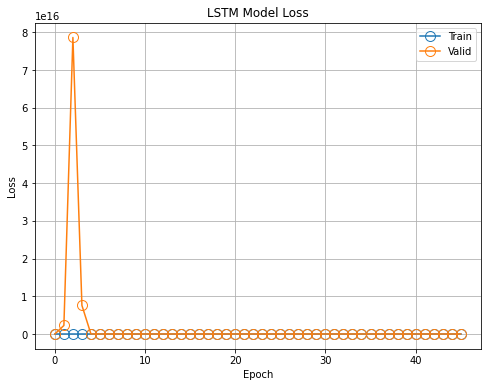

In [ ]:
plot_1(history1, 'Training / Validation Losses from History')

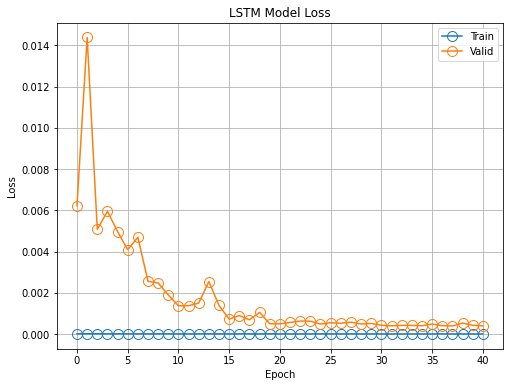

In [ ]:
plot_1(history1, 'Training / Validation Losses from History')

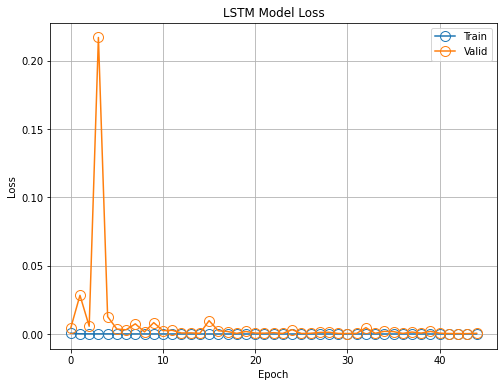

In [ ]:
plot_1(history1, 'Training / Validation Losses from History')

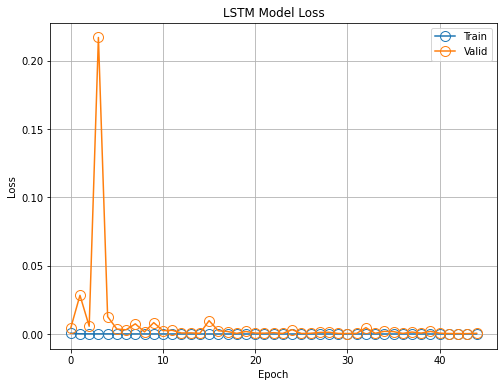

In [ ]:
plot_1(history1, 'Training / Validation Losses from History')

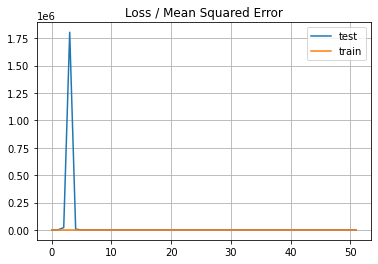

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.plot(history1.history['loss'], label='train')
pyplot.legend()
pyplot.show()

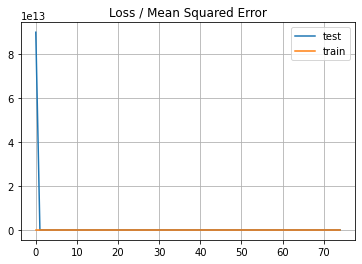

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.plot(history1.history['loss'], label='train')
pyplot.legend()
pyplot.show()

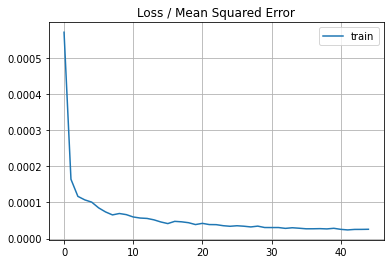

In [ ]:
pyplot.title('Loss / Mean Squared Error')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.plot(history1.history['loss'], label='train')
pyplot.legend()
pyplot.show()

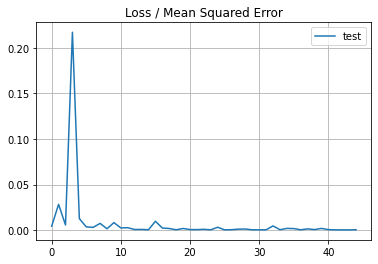

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history1.history['val_loss'], label='test')
#pyplot.plot(history1.history['loss'], label='train')
pyplot.legend()
pyplot.show()

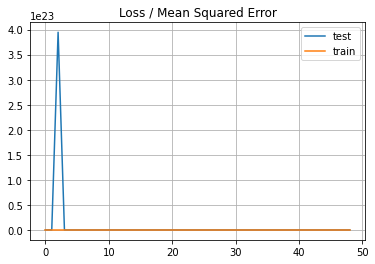

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.plot(history1.history['loss'], label='train')
pyplot.legend()
pyplot.show()

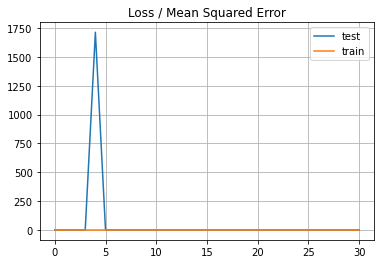

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.plot(history1.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'],loc='upper right')
plt.show()

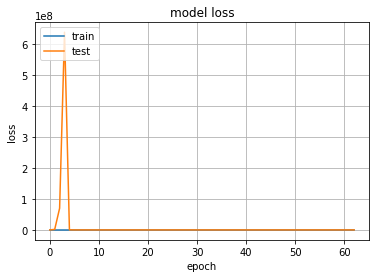

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

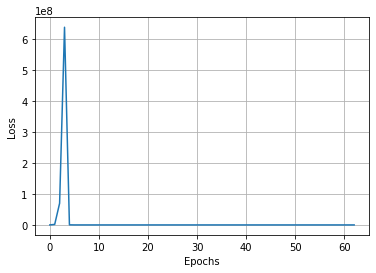

In [ ]:
plt.plot(history1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

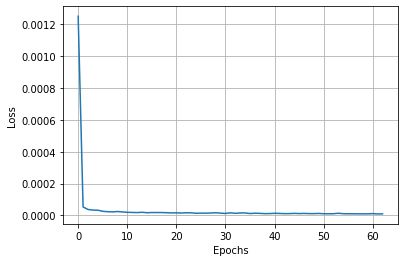

In [ ]:
plt.plot(history1.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
train_predict=modell.predict(X_train)
test_predict=modell.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

90.12779797520199

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20.744551350170173

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

83.66756700809603

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20.288486227849145

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

87.73902439514092

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20.99294981117082

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

88.8028633263623

In [ ]:
# create the list of difference between prediction and test data
predictions = modell.predict(X_test)
len(predictions)

942

In [ ]:
def plot_1(history, title):
  """function that plots the loss results of the model"""
  plt.figure(figsize=(8,6))
  plt.plot(history1.history['loss'], 'o-', mfc='none', markersize=10, 
  label='Train')
  plt.plot(history1.history['val_loss'], 'o-', mfc='none', 
  markersize=10, label='Valid')
  plt.title('LSTM Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


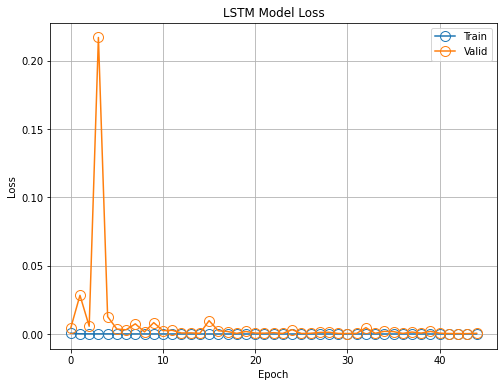

In [ ]:
plot_1(history1, 'Training / Validation Losses from History')

In [ ]:
def evaluate_predictions(predictions, ytest, outliers):
    ratio = []
    differences = []
    for pred in range(len(ytest)):
        ratio.append((ytest[pred]/predictions[pred])-1)
        differences.append(abs(ytest[pred]- predictions[pred]))
    
    
    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)
    
    return ratio, differences, outliers

In [ ]:
ratio, differences, outliers = evaluate_predictions(predictions, ytest, 0.01)

In [ ]:
for index in outliers.index: 
    outliers[index] = predictions[index]
outliers

651    0.895588
649    0.908479
653    0.857305
650    0.903704
652    0.875325
654    0.834203
867    1.017309
734    0.902744
687    0.799588
dtype: float64

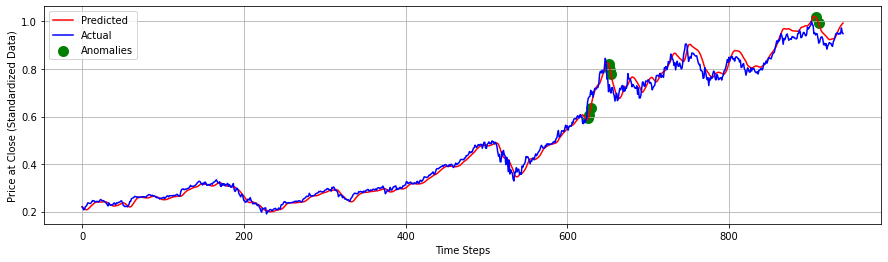

In [ ]:

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions,color='red', label='Predicted')
axs.plot(ytest,color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.legend(loc='upper left')
plt.show()

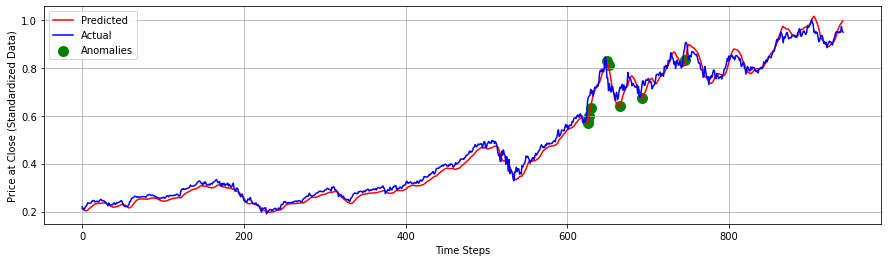

In [ ]:

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions,color='red', label='Predicted')
axs.plot(ytest,color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.legend(loc='upper left')
plt.show()

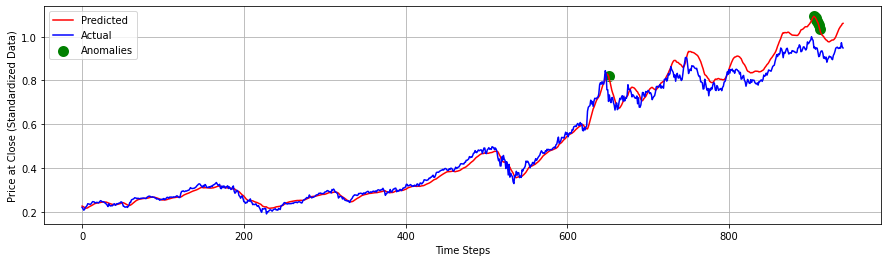

In [ ]:

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions,color='red', label='Predicted')
axs.plot(ytest,color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.legend(loc='upper left')
plt.show()

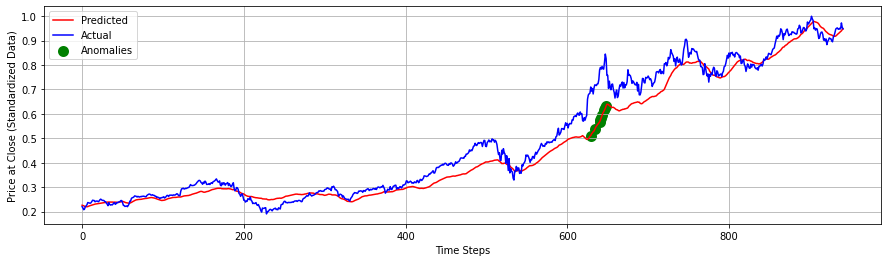

In [ ]:

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions,color='red', label='Predicted')
axs.plot(ytest,color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.legend(loc='upper left')
plt.show()

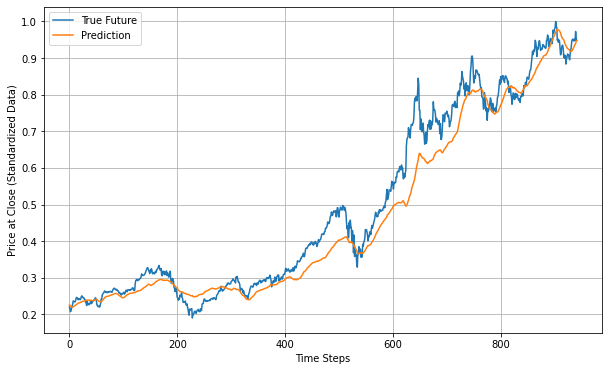

In [ ]:
# Plot true future vs prediction plot true future (test data) vs prediction the three models.
plt.figure(figsize=(10, 6))
range_future = len(predictions)
plt.plot(np.arange(range_future), np.array(ytest), 
             label='True Future')     
plt.plot(np.arange(range_future),np.array(predictions),
            label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.show()


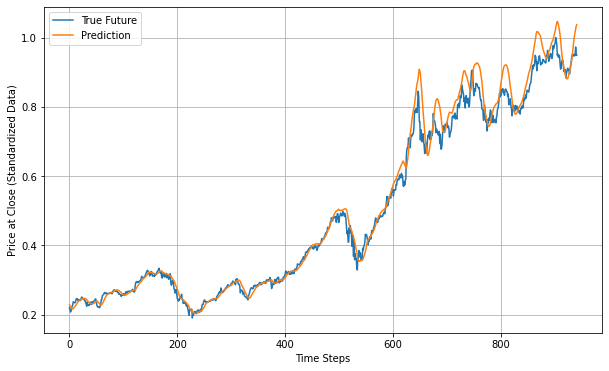

In [ ]:
# Plot true future vs prediction plot true future (test data) vs prediction the three models.
plt.figure(figsize=(10, 6))
range_future = len(predictions)
plt.plot(np.arange(range_future), np.array(ytest), 
             label='True Future')     
plt.plot(np.arange(range_future),np.array(predictions),
            label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('Time Steps')
plt.ylabel('Price at Close (Standardized Data)')
plt.show()
